# Import packages and setting up

In [1]:
# plotting library
import matplotlib.pyplot as plt
import seaborn as snn

# numpy
import numpy as np
from numpy.random import Generator as gen
from numpy.random import PCG64 as pcg

# scipy 
from scipy.stats import truncnorm

# pandas
import pandas as pd

C:\Users\Tuyen\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# for pretty plotting
snn.set()

In [3]:
# for pretty printing of numpy arrays
np.set_printoptions(suppress=True) # suppress scientific notation

In [4]:
random_generator = gen(pcg(seed=259))

# Gritsun SNN
Based on the neuronal network model found in https://link.springer.com/content/pdf/10.1007/s00422-010-0366-x.pdf

## Neuronal Feature class

Configure neurons in the network (See Gritsun Paper)

    * excitatory_neuron_setting = {
        'a': 0.02,
        'b': 0.2,
        'c': -65 + 15*r_i
        'd': 8 - 6*r_i
    }
    
    * inhibitory_neuron_setting = {
        'a': 0.02 + 0.08*r_i
        'b': 0.25 - 0.05*r_i
        'c': -65,
        'd': 2
    }
    
    Note: r_i is a random variable normally distributed on the interval [0,1]
    
    * pacemaker_neuron_setting
    
    Version 1: Gritsun paper: the same setting as the excitatory_neuron_setting but has different b parameter
    pacemaker_neuron_setting_v1 = {
        'b': 0.26
    }
    
    Version 2: What Dr. Lowe found, the same setting as the excitatory_neuron_setting but has an additional Internal Pacemaker increase p
    pacemaker_neuron_setting_v2 = {
        'p': 1 
    }
 


In [5]:
# A function to obtain a normal distribution within a range
def get_truncated_normal_list(mean=0, sd=1, low=0, upp=1, size=1000):
    return list(
                truncnorm(
                    (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd
                )
                .rvs(size)
            )


In [35]:
'''
Neuronal Feature Class
'''
class NeuronalFeature:
    
    def __init__(self, n, R, pm_fraction, pacemaker_version):
        '''
        Construtor params:
        n: define the total number of neurons in the network
        R: Excitatory Fraction - the percentage of Excitatory neurons in the network
        pm_fraction: Pacemaker Fraction - the percentage of pacemaker neurons in the network
        pacemaker_version: 1 or 2
        
        Create Pacemakers, other Excitatory neurons, and Inhibitory Neurons for the network using the Spiking Neuron class
        '''    
        # calculate the number of excitatory neurons
        Ec_number = int(n*R)
        
        # calculate the number of pacemaker neurons
        pm_number = int(n*pm_fraction)
        
        # calculate the number of inhibitory neurons
        Ih_number = n - Ec_number - pm_number
        
        # Generates n number of r_i between 0 and 1, normally distributed
        r_i_queue = get_truncated_normal_list(mean=0, sd=1, low=0, upp=1, size=n*2)
               
        # neurons parameters
        self.array_a = []
        self.array_b = []
        self.array_c = []
        self.array_d = []
        self.array_p = 0
        self.array_initial_v = []
        self.array_e = []
        
        # set excitatory neurons' parameters
        self.array_a.extend([0.02]*Ec_number)
        self.array_b.extend([0.2]*Ec_number)
        self.array_c.extend([-65 + 15 * r_i_queue.pop() for i in range(Ec_number)])
        self.array_d.extend([8 - 6 * r_i_queue.pop() for i in range(Ec_number)])
        self.array_initial_v.extend([-65]*Ec_number)
        self.array_e.extend([1]*Ec_number)
        
        # set inhibitory neurons' parameters
        self.array_a.extend([0.02 + 0.08 * r_i_queue.pop() for i in range(Ih_number)])
        self.array_b.extend([0.25 - 0.05 * r_i_queue.pop() for i in range(Ih_number)])
        self.array_c.extend([-65]*Ih_number)
        self.array_d.extend([2]*Ih_number)
        self.array_initial_v.extend([-65]*Ih_number)
        self.array_e.extend([-1]*Ih_number)
        
        self.first_pacemaker_number = Ec_number + Ih_number
        # Create pacemaker neurons
        self.array_a.extend([0.02]*pm_number)
        self.array_b.extend([0.26]*pm_number)
        self.array_c.extend([-65 + 15 * r_i_queue.pop() for i in range(pm_number)])
        self.array_d.extend([8 - 6 * r_i_queue.pop() for i in range(pm_number)])
        self.array_initial_v.extend([-65]*pm_number)
        self.array_e.extend([1]*pm_number)
        
        # convert to np arrays
        self.array_a = np.array(self.array_a).astype('float')
        self.array_b = np.array(self.array_b).astype('float')
        self.array_c = np.array(self.array_c).astype('float')
        self.array_d = np.array(self.array_d).astype('float')
        self.array_initial_v = np.array(self.array_initial_v).astype('float')
        self.array_e = np.array(self.array_e).astype('float')
            
        # number of neurons in the network
        self.n = n
        
        # set initial membrane potential and recovery variables
        self.reset_neurons()
         
   
    def reset_neurons(self):
        '''
        Reset the neurons to its default state
        '''
         # membrane potential 
        self.array_V = self.array_initial_v
        
        # recovery variable
        self.array_U = self.array_V * self.array_b
    
    
    def get_pacemaker_neurons_number(self):
        '''
        get the number representation of pacemaker neurons
        '''        
        return np.arange(self.first_pacemaker_number, self.n)
    
    def update_neurons_membrane_potentials(self):        
        # if the membrane potential is less than 30mV (before-spike stage), 
        # adjust the membrane potential v_t according to the two differential equations defined in Izhikevich's simple Model of Spiking Neurons
        # if the membrane potential reach its apex at 30mv (after-spike stage), 
        # reset the membrane potential and recovery variable using parameters c and d
        self.array_V = np.where(self.array_V<30, 
                                self.array_V+ 0.04*self.array_V**2 + 5*self.array_V + 140 - self.array_U + self.array_p,
                                self.array_c)
        
        self.array_U = np.where(self.array_V<30, 
                                self.array_U + self.array_a*(self.array_b*self.array_V-self.array_U),
                                self.array_U + self.array_d)

        return self.array_V

##### Some test on the class

In [36]:
neuronal_feature = NeuronalFeature(n=100, R=0.7, pm_fraction=0.14, pacemaker_version=1)


In [37]:
np.unique(neuronal_feature.array_V)

array([-65.])

In [38]:
np.unique(neuronal_feature.array_U)

array([-16.9       , -16.23569821, -15.92427032, -15.78080491,
       -15.65412127, -15.58946844, -15.30143381, -15.15135521,
       -14.81240506, -14.6025537 , -14.47843619, -14.35031509,
       -14.27225352, -14.17798117, -13.78488596, -13.36840574,
       -13.32980721, -13.        ])

In [39]:
neuronal_feature.update_neurons_membrane_potentials()

array([-68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.        ,
       -68.        , -68.        , -68.        , -68.  

In [40]:
np.unique(neuronal_feature.array_V)

array([-68.        , -67.67019279, -67.63159426, -67.21511404,
       -66.82201883, -66.72774648, -66.64968491, -66.52156381,
       -66.3974463 , -66.18759494, -65.84864479, -65.69856619,
       -65.41053156, -65.34587873, -65.21919509, -65.07572968,
       -64.76430179, -64.1       ])

In [41]:
neuronal_feature.array_a.shape

(100,)

In [42]:
np.min(neuronal_feature.array_a), np.max(neuronal_feature.array_a)

(0.02, 0.09679442238524816)

In [43]:
np.min(neuronal_feature.array_b), np.max(neuronal_feature.array_b)

(0.2, 0.26)

In [44]:
np.min(neuronal_feature.array_c), np.max(neuronal_feature.array_c)

(-65.0, -50.2856963668555)

In [45]:
np.min(neuronal_feature.array_d), np.max(neuronal_feature.array_d)

(2.0, 7.871754164470415)

In [46]:
np.unique(neuronal_feature.array_p)

array([0])

In [47]:
np.unique(neuronal_feature.array_initial_v)

array([-65.])

In [48]:
np.unique(neuronal_feature.array_e)

array([-1.,  1.])

## Synaptic Feature class

Using the activity-dependent synapse model: Short-term Spiking Plasticity (See Gritsun paper and <a href="http://www.scholarpedia.org/article/Short-term_synaptic_plasticity">Short-term synaptic plasticity - Scholarpedia</a> for more detail)

In [71]:
'''
Instance variables:
    In this class, every self.network_ is a matrix, where rows represent post-synaptic neurons, and columns represent pre-synaptic neurons

    self.network_connections: each row in the matrix corresponds to a specific neuron which receives (1) or not receive (0) synaptic connections from neurons represented by the columns 
    
    self.network_trans_latency:  each value in the matrix represents the transmission latency of a synaptic connection or 0 if there is no synaptic connection
    
    self.network_U: each value in the matrix represents the fraction of available resources consumed to produce the post synaptic currents of the first spike (Between 0 and 1)
    
    self.network_y: each value in the matrix represents the fraction of available resources consumed to produce the post synaptic currents (Between 0 and 1) (initially network_y=network_U)
    
    self.network_B: each value in the matrix represents the fraction of resources that remain available after neurotransmitter depletion. (Between 0 and 1)
    
    self.network_delta: each value in the matrix represents the depression time constant
    
    self.network_F: each value in the matrix represents the facilitation time constant
'''
class SynapticFeature:
    def __init__(self, K_max, D_max, n, array_e, A):
        '''
        Constructor Params:
    
        K_max: is the max connectivity 
            Neurons had random number of connections, normally distributed between 0 and K_max
            K_max: 100-1100 
    
        D_max: The maximum transmission delay
            Neurons' transmission delays ranged between 1 and Dmax with a normal distribution
            D_max: 5ms-25ms 
    
        n: is the number of neurons
        array_e: an array of excitatory indicator, indicating whether neuron is an excitatory neuron (1) or inhibitory neuron (-1)
    
        A: 1D array, each value is the synaptic response amplitude that would be produced by total release of all the neurotransmitter (when B=y=1)
        Assumes x is a value in A => x in {1,12} where x=12 if the neuron is a pacemaker, otherwise x=1
        '''
        self.network_connections = self.set_up_connections(n, K_max)
        self.network_trans_latency = self.set_up_trans_latency(self.network_connections, n, D_max)
        self.network_U, self.network_delta, self.network_F = self.set_up_synapse_params(array_e, self.network_connections)
        self.reset_synapses()
        
        self.A = A
        
    def reset_synapses(self):
        '''
        Reset the synapses to its default state
        '''
        self.network_y = self.network_U.copy() # y initially set to be U
        self.network_B = self.network_connections.copy().astype("float") # B initially set to be 1, for no synaptic connection = 0
    
    def set_up_connections(self, n, K_max):
        '''
        set up synaptic connections/synapses for n neurons 
        (similarly to set up a graph: 1 for synaptically connected, and 0 for not synaptically connected)
            
        Params:
            n: is the number of neurons
            K_max: is the maximum number of synaptic connections per neuron (per row)
                
        Return: a matrix of 1s and 0s
        '''
        # a pool of connectivity value for the n neurons
        # values are between 0 and K_max + randomly generated using Normal Distribution 
        connectivities = get_truncated_normal_list(mean=K_max/2, sd=K_max/4, low=0, upp=K_max, size=n)
        print("# Number of connections Min: ", min(connectivities))
        print("# Number of connections Max: ", max(connectivities))
        
        # create synaptic connections for each neuron in the network of n neurons
        
        network_connections = []         # network_connections: n X n array
        
        for neuron_number, connectivity in enumerate(connectivities):
            neuron_connections = np.array([1]*int(connectivity)+[0]*int(n-int(connectivity)))
            
            # shuffle 
            random_generator.shuffle(neuron_connections)
            
            # append the neuron's connection to the network
            network_connections.append(neuron_connections)
        
        # convert to nd-array
        network_connections = np.array(network_connections)
        
        # no connections to itself
        np.fill_diagonal(network_connections, 0)
        
        return network_connections
    
    def set_up_trans_latency(self, network_connections, n, D_max):
        '''
        set up tranmission delays for each connection in the network
            
        Params:
            network_connections: matrix of 1s and 0s, 1 indicates there is a synaptic connection
            n: is the number of neurons
            D_max: the maximum transmission latency
                
        Return: a matrix of transmission latency, 0 at locations where there is no synaptic connection
        '''
        network_trans_latency = np.array([get_truncated_normal_list(mean=D_max/2, sd=D_max/4, low=1, upp=D_max, size=n) for neuron_index in range(n)])
        
        # set transmission latency to be 0 at locations where there is no synaptic connection
        network_trans_latency = np.where(network_connections==0, 0, network_trans_latency)
        
        # change the type to int 
        network_trans_latency = network_trans_latency.astype("int")
        
        print("# Transmission Latency Min: ", np.min(network_trans_latency))
        print("# Transmission Latency Max: ", np.max(network_trans_latency))
        
        return network_trans_latency    
    
    def set_up_synapse_params(self, array_e, network_connections):
        '''
        set up synapse constants
        
        Params:
            array_e: an array of excitatory indicators, each indicates whether neuron is an excitatory neuron (1) or inhibitory neuron (-1)
            network_connections: matrix of 1s and 0s, 1 indicates there is a synaptic connection
            
        Return: a matrix of utilization constant, a matrix of depression time constant, and a matrix of utilization time constant 
        '''
        # find the excitatory neuron
        excitatory_neurons_number = np.argwhere(array_e==1).squeeze()

        # find the inhibitory neuron
        inhibitory_neurons_number = np.argwhere(array_e==-1).squeeze()
        
        # initialize parameters with 0
        network_U = np.zeros_like(network_connections, dtype="float")
        network_delta = np.zeros_like(network_connections, dtype="float")
        network_F = np.zeros_like(network_connections, dtype="float")
        
        # fill E-E connection with initial_U = 0.59, initial_delta = 0.813, initial_F = 0
        network_U[np.ix_(excitatory_neurons_number, excitatory_neurons_number)] = 0.59
        network_delta[np.ix_(excitatory_neurons_number, excitatory_neurons_number)] = 0.813
        network_F[np.ix_(excitatory_neurons_number, excitatory_neurons_number)] = 0
        
        # fill E-I connection with initial_U = 0.049, initial_delta = 0.399, initial_F = 1.797
        network_U[np.ix_(inhibitory_neurons_number, excitatory_neurons_number)] = 0.049
        network_delta[np.ix_(inhibitory_neurons_number, excitatory_neurons_number)] = 0.399
        network_F[np.ix_(inhibitory_neurons_number, excitatory_neurons_number)] = 1.797
        
        # fill I-E connection with initial_U = 0.16, initial_delta = 0.045, initial_F = 0.376
        network_U[np.ix_(excitatory_neurons_number, inhibitory_neurons_number)] = 0.16
        network_delta[np.ix_(excitatory_neurons_number, inhibitory_neurons_number)] = 0.045
        network_F[np.ix_(excitatory_neurons_number, inhibitory_neurons_number)] = 0.376
        
        
        # fill I-I connection with initial_U = 0.25, initial_delta = 0.706, initial_F = 0.021
        network_U[np.ix_(inhibitory_neurons_number, inhibitory_neurons_number)] = 0.25
        network_delta[np.ix_(inhibitory_neurons_number, inhibitory_neurons_number)] = 0.706
        network_F[np.ix_(inhibitory_neurons_number, inhibitory_neurons_number)] = 0.021
        
        # set U, delta, F to be 0 at those locations where there are no synaptic connection
        network_U = np.where(network_connections==0, 0, network_U)
        network_delta = np.where(network_connections==0, 0, network_delta)
        network_F = np.where(network_connections==0, 0, network_F)
        
        return (network_U, network_delta, network_F)
    
   
    def calculate_weights_at_current_time_step(self, firing_presynaptic_neurons):
        '''
        calculate_weights_at_current_time_step helps calculate w_ij when the presynaptic neuron j spikes
        
        Params: 
            firing_presynaptic_neurons: is a 1D array, numbers indicating which neurons are firing
            
        Return: the updated weights of synaptic connections in the network at the current time step
        '''
        # calculate new network_y for those presynaptic neurons that are firing
        network_y_new = self.network_y.copy()
        
        extracted_U = self.network_U[:, firing_presynaptic_neurons]
        extracted_y_previous = self.network_y[:, firing_presynaptic_neurons]
        extracted_delta = self.network_delta[:, firing_presynaptic_neurons]
        extracted_F = self.network_F[:, firing_presynaptic_neurons]
        
        network_y_new[:, firing_presynaptic_neurons] =  np.where(self.network_connections[:, firing_presynaptic_neurons]==0, 
                                                                 0, 
                                                                 extracted_U + extracted_y_previous*(1-extracted_U)*np.exp(
                                                                                                                        np.divide(-extracted_delta, extracted_F, where=(extracted_F!=0), out = np.zeros_like(extracted_y_previous, dtype="float"))))
        
        # calculate new network_B for those presynaptic neurons that are firing
        network_B_new = self.network_B.copy()
        
        extracted_B_previous = self.network_B[:, firing_presynaptic_neurons]
        
        network_B_new[:, firing_presynaptic_neurons] = np.where(self.network_connections[:, firing_presynaptic_neurons]==0, 
                                                                0, 
                                                                1 + (extracted_B_previous - extracted_y_previous * extracted_B_previous - 1)*np.exp(np.divide(-extracted_delta, extracted_F, where=(extracted_F!=0), out = np.zeros_like(extracted_B_previous, dtype="float"))))

        # updates
        self.network_y = network_y_new
        self.network_B =  network_B_new
                
        # calculate weights 
        network_weights = self.A * self.network_y * self.network_B
        
        return network_weights 
        

##### Test the set_up_connections method

In [59]:
array_e = np.array([1]*800+[-1]*200)
random_generator.shuffle(array_e)
synaptic_feature = SynapticFeature(K_max=100, D_max=25, n=1000, array_e=array_e, A=np.full((1000, ), 1))
network_connections = synaptic_feature.network_connections

# Number of connections Min:  0.15181398428673276
# Number of connections Max:  99.99510159800832
# Transmission Latency Min:  0
# Transmission Latency Max:  24


In [60]:
network_connections.sum() #number of connections within the networl

50552

In [61]:
num_connections = network_connections.sum(axis=1) # number of connections of 1000 neurons

In [62]:
num_connections.shape # 1000 neurons

(1000,)

In [63]:
num_connections[:10] # number of connections of the first 10 neurons

array([53, 78, 21, 50,  4, 65, 36, 31, 29, 37])

##### Test set_up_trans_latency method

In [65]:
array_e = np.array([1]*800+[-1]*200)
random_generator.shuffle(array_e)
synaptic_feature = SynapticFeature(K_max=100, D_max=25, n=1000, array_e=array_e, A=np.full((1000, ), 1))
network_connections = synaptic_feature.network_connections
network_trans_latency = synaptic_feature.network_trans_latency


# Number of connections Min:  0.06907051778677697
# Number of connections Max:  99.75131980361422
# Transmission Latency Min:  0
# Transmission Latency Max:  24


In [66]:
network_connections.sum()

49489

In [67]:
np.argwhere(network_trans_latency != 0).shape[0]

49489

In [68]:
list([network_trans_latency[0, loc] for loc in np.argwhere(network_trans_latency[0, :]!=0).squeeze().tolist()])
# transmission delays of connections to the first neuron

[12,
 18,
 18,
 11,
 15,
 19,
 17,
 10,
 7,
 6,
 12,
 2,
 21,
 13,
 11,
 6,
 3,
 18,
 10,
 18,
 8,
 12,
 14,
 14,
 13,
 20]

In [69]:
network_connections[0, :100],  network_trans_latency[0, :100]

(array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([ 0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0]))

##### Test set_up_inital_utilization_param

In [73]:
array_e = np.array([1]*800+[-1]*200)
random_generator.shuffle(array_e)
synaptic_feature = SynapticFeature(K_max=100, D_max=25, n=1000, array_e=array_e, A=np.full((1000, ), 1))
network_connections = synaptic_feature.network_connections
network_trans_latency = synaptic_feature.network_trans_latency
network_U, network_delta, network_F = synaptic_feature.network_U, synaptic_feature.network_delta, synaptic_feature.network_F

# Number of connections Min:  0.06731170808712506
# Number of connections Max:  99.96990418852371
# Transmission Latency Min:  0
# Transmission Latency Max:  24


In [74]:
np.unique(network_U)

array([0.   , 0.049, 0.16 , 0.25 , 0.59 ])

In [75]:
np.unique(network_delta)

array([0.   , 0.045, 0.399, 0.706, 0.813])

In [76]:
np.unique(network_F)

array([0.   , 0.021, 0.376, 1.797])

In [77]:
np.unique(network_U[np.ix_(np.argwhere(array_e==-1).squeeze(), np.argwhere(array_e==-1).squeeze())])

array([0.  , 0.25])

##### Test calculate_weights_at_current_time_step

In [ ]:
array_e = np.array([1]*800+[-1]*200)
random_generator.shuffle(array_e)
synaptic_feature = SynapticFeature(array_e=array_e, A=1)
network_trans_latency = synaptic_feature.network_trans_latency
network_connections = synaptic_feature.network_connections
network_U, network_delta, network_F = synaptic_feature.network_U, synaptic_feature.network_delta, synaptic_feature.network_F


# Number of connections Min:  0.22154288273229383
# Number of connections Max:  99.33919951754888
# Transmission Latency Min:  0
# Transmission Latency Max:  24


In [ ]:
np.unique(synaptic_feature.network_y, return_counts=True) # at the beginning

(array([0.   , 0.049, 0.16 , 0.25 , 0.59 ]),
 array([950404,   8051,   7885,   2021,  31639]))

In [ ]:
np.unique(synaptic_feature.network_B, return_counts=True) # at the beginning

(array([0., 1.]), array([950404,  49596]))

In [ ]:
# first spikes
firing_presynaptic_neurons = np.arange(0, 1000,2)
network_weight_k = synaptic_feature.calculate_weights_at_current_time_step(firing_presynaptic_neurons)

In [ ]:
pd.DataFrame(np.array([*np.unique(synaptic_feature.network_y, return_counts=True)]).T, columns=['y', 'count'])

,y,count
0,0.00000,950404.0
1,0.04900,4038.0
2,0.08632,4013.0
3,0.16000,3919.0
4,0.25000,988.0
5,0.25000,1033.0
6,0.27924,3966.0
7,0.59000,15895.0
8,0.83190,15744.0


In [ ]:
pd.DataFrame(np.array([*np.unique(synaptic_feature.network_B, return_counts=True)]).T, columns=['B', 'count'])

,B,count
0,0.000000,950404.0
1,0.410000,15744.0
2,0.858047,3966.0
3,0.960757,4013.0
4,1.000000,1033.0
5,1.000000,24840.0


In [ ]:
pd.DataFrame(np.array([*np.unique(network_weight_k, return_counts=True)]).T, columns=['weight', 'count'])

,weight,count
0,0.000000,950404.0
1,0.049000,4038.0
2,0.082933,4013.0
3,0.160000,3919.0
4,0.239601,3966.0
5,0.250000,988.0
6,0.250000,1033.0
7,0.341079,15744.0
8,0.590000,15895.0


In [ ]:
network_weight_k

array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.59    , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.341079, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

Resimulation to compare: All possible network_y after the first spike

In [ ]:
U_possible = np.array([0.59, 0.049, 0.16 , 0.25]) # E-E, E-I, I-E, I-I
y_previous_possible = U_possible.copy()
delta_possible = np.array([0.813, 0.399, 0.045, 0.706])
F_possible = np.array([0, 1.797, 0.376, 0.021])
B_previous_possible = np.array([1])

In [ ]:
network_y_altered_possible = U_possible + y_previous_possible*(1-U_possible)*np.exp(np.divide(-delta_possible, F_possible, where=F_possible!=0, out=np.zeros_like(y_previous_possible)))


In [ ]:
network_y_altered_possible

array([0.8319    , 0.08632048, 0.27924016, 0.25      ])

In [ ]:
np.sort(np.concatenate((network_y_altered_possible, U_possible))) # all possible y

array([0.049     , 0.08632048, 0.16      , 0.25      , 0.25      ,
       0.27924016, 0.59      , 0.8319    ])

All possible B after the first spike

In [ ]:
network_B_altered_possible = 1 + (B_previous_possible - y_previous_possible * B_previous_possible - 1)*np.exp(np.divide(-delta_possible, F_possible, where=(F_possible!=0), out = np.zeros_like(y_previous_possible, dtype="float")))
                                                                                    

In [ ]:
np.sort(network_B_altered_possible)

array([0.41      , 0.85804743, 0.96075659, 1.        ])

## Gritsun SNN class

In [ ]:
class GritsunSNN:
    def __init__(self, 
                 n=5000, 
                 R=0.8, 
                 pm_fraction=0.04, 
                 pacemaker_version=1, 
                 K_max=1000, 
                 D_max=15, 
                 J=0):
        '''
        Construtor params:
        n: the total number of neurons in the network
        R: Excitatory Fraction - the percentage of Excitatory neurons in the network
        pm_fraction: Pacemaker Fraction - the percentage of pacemaker neurons in the network
        pacemaker_version: 1 or 2
        K_max: is the maximum connectivity per neuron
        D_max: The maximum transmission delay    
        J: synaptic noise
        
        The default parameter setting is from a pacemaker-driven NN with adaptive synapses example in Gritsun Paper (see Fig.9-Gritsun)
        '''
        # Neuronal model
        self.neuronal_feature = NeuronalFeature(n=n, 
                                                R=R, 
                                                pm_fraction=pm_fraction, 
                                                pacemaker_version=pacemaker_version)
        
        # Synaptic model
        pacemaker_locations= self.neuronal_feature.get_pacemaker_neurons_number()
        A = np.ones(self.neuronal_feature.n, dtype="float")
        A[pacemaker_locations] = 12
        
        self.synaptic_feature = SynapticFeature(K_max=K_max, 
                                                D_max=D_max, 
                                                n=n, 
                                                array_e=self.neuronal_feature.array_e, 
                                                A = A)
        
        self.J = J
        self.D_max = D_max
        
    def simulate(self, ms = 10):
        '''
        Run the network simulation.
        
        Params:
            ms: the number of milliseconds to simulate
        '''
        f_i_history = [] # 2D list, first dimension is the time step, and second dimension is an array of neuron's f(i) at the time step
        
        # reset
        self.neuronal_feature.reset_neurons()
        self.synaptic_feature.reset_synapses()
        
        # spiking history: 2D array: time step - presynaptic neuron
        spiking_history = np.tile(np.zeros((1,self.neuronal_feature.n)), (self.D_max, 1))
        print("Spiking History Shape: ", spiking_history.shape)

        # weight history: 3D array: time step - postsynaptic - presynaptic
        network_initial_weight = np.zeros_like(self.synaptic_feature.network_connections)
        weight_history = np.tile(network_initial_weight, (self.D_max, 1,1))
        print("Weight History Shape: ", weight_history.shape)

        # mask_i: for indexing
        mask_i = np.repeat(np.arange(0,self.neuronal_feature.n), self.neuronal_feature.n).reshape(self.neuronal_feature.n, -1)
        print("mask i: ", mask_i)
        
        # mask_j: for indexing
        mask_j = np.tile(np.arange(0,self.neuronal_feature.n), self.neuronal_feature.n).reshape(self.neuronal_feature.n, -1)
        print("mask j: ", mask_j)
        
        # transmission latency
        array_trans_latency = self.synaptic_feature.network_trans_latency
        mask_latency = array_trans_latency - 1
        print("mask_latency: ", mask_latency)
        
        # excitatory or inhibitory presynaptic neurons
        array_e = np.tile(self.neuronal_feature.array_e, (5000,1))
        
        for time_step in range(ms): 
            # neuron computation
            integrated_synaptic_input = np.sum(np.where(self.synaptic_feature.network_connections==1, weight_history[mask_latency, mask_i, mask_j], 0)
                                               *array_e
                                               *spiking_history[mask_latency, mask_j], 
                                               axis=1)
            print('*** At time ', time_step, 'ms, integrated_synaptic_input = ', integrated_synaptic_input) 
            
            f_i = self.neuronal_feature.update_neurons_membrane_potentials() + self.J + integrated_synaptic_input
            print('f_i = ', f_i)
            f_i_history.append(f_i)

            
            # neuron spiking
            spiking_pattern = np.where(f_i>=30, 1, 0)
            spiking_history = np.append(spiking_history, [spiking_pattern], axis=0)[1:]
            
            spiking_neuron_numbers = np.argwhere(spiking_pattern==1).squeeze().tolist()            
            weight_history = np.append(weight_history, [self.synaptic_feature.calculate_weights_at_current_time_step(spiking_neuron_numbers)], axis=0)[1:]
            print('spike neurons: ', spiking_neuron_numbers)
        
        return np.array(f_i_history)
        
        

In [ ]:
def draw_spike_raster(history, firing_level = 30):
    img_data = (history >= firing_level) * 1
    fig,ax = plt.subplots()
    ax.imshow(img_data, interpolation="nearest", aspect='auto', cmap="Greys")
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron Number')
    plt.show()

In [ ]:
snn = GritsunSNN()
f_i_history = snn.simulate(1000)

# Number of connections Min:  0.11995722764595484
# Number of connections Max:  999.0396210481008
# Transmission Latency Min:  0
# Transmission Latency Max:  14
Spiking History Shape:  (15, 5000)
Weight History Shape:  (15, 5000, 5000)
mask i:  [[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [4997 4997 4997 ... 4997 4997 4997]
 [4998 4998 4998 ... 4998 4998 4998]
 [4999 4999 4999 ... 4999 4999 4999]]
mask j:  [[   0    1    2 ... 4997 4998 4999]
 [   0    1    2 ... 4997 4998 4999]
 [   0    1    2 ... 4997 4998 4999]
 ...
 [   0    1    2 ... 4997 4998 4999]
 [   0    1    2 ... 4997 4998 4999]
 [   0    1    2 ... 4997 4998 4999]]
mask_latency:  [[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 11]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [10 -1 -1 ... -1 -1 -1]]
*** At time  0 ms, integrated_synaptic_input =  [0. 0. 0. ... 0. 0. 0.]
f_i =  [-67.805   -67.805   -67.805   ... -64.1

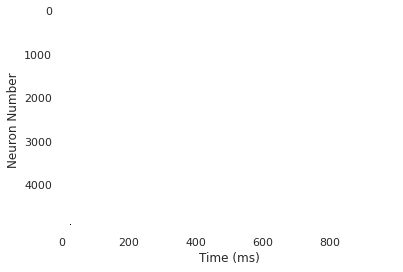

In [ ]:
draw_spike_raster(f_i_history.T)

In [ ]:
f_i_history.T.shape

(5000, 1000)

In [70]:
x = np.array([[1,2,3,4], [5,6,7,8],[9,10,11,12], [13,14,15,16]])
x[np.ix_([0,2], [0,2])]

array([[ 1,  3],
       [ 9, 11]])